In [ ]:
# LMS Performance Predictor - Model Building
# This notebook builds LSTM models to predict:
# 1. Server load patterns
# 2. Database performance
# 3. API response times
# 4. Storage capacity trends
# 5. Scaling needs and peak usage times
# 6. Crash risk during exam periods

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta

In [ ]:
# Generate comprehensive LMS performance data
# Simulating 60 days of hourly data with realistic patterns
np.random.seed(42)
n_hours = 60 * 24  # 60 days
time = np.arange(0, n_hours)

# Create timestamp range
start_date = datetime(2024, 1, 1)
timestamps = pd.date_range(start_date, periods=n_hours, freq='h')

# 1. Server Load (CPU Usage %) - Higher during exam periods
# Base load with daily patterns + weekly patterns + exam spikes
base_load = 40
daily_pattern = 15 * np.sin(time / 24 * 2 * np.pi)  # Daily cycle
weekly_pattern = 10 * np.sin(time / (24 * 7) * 2 * np.pi)  # Weekly cycle
exam_spikes = np.zeros(n_hours)
# Add exam periods (every 2 weeks, 3 days duration)
for i in range(0, n_hours, 14 * 24):
    exam_spikes[i:i+72] = 25 + 10 * np.random.random(72)  # 3 days of high load
server_load = base_load + daily_pattern + weekly_pattern + exam_spikes + np.random.normal(0, 3, n_hours)
server_load = np.clip(server_load, 0, 100)

# 2. Database Performance (Query Response Time in ms)
# Correlates with server load but with some lag
db_base = 50
db_load = db_base + (server_load * 0.8) + np.random.normal(0, 5, n_hours)
db_performance = np.clip(db_load, 20, 500)  # Response time in ms

# 3. API Response Times (ms)
# Similar to DB but with different characteristics
api_base = 30
api_load = api_base + (server_load * 0.6) + np.random.normal(0, 3, n_hours)
api_response_time = np.clip(api_load, 10, 300)

# 4. Storage Capacity (GB used)
# Gradually increasing with occasional spikes
storage_base = 500
storage_trend = np.linspace(0, 200, n_hours)  # Gradual increase
storage_spikes = np.random.choice(n_hours, size=20, replace=False)
storage_capacity = storage_base + storage_trend
for spike in storage_spikes:
    storage_capacity[spike:] += np.random.uniform(5, 15)
storage_capacity = np.clip(storage_capacity, 500, 1000)

# Create comprehensive dataframe
df = pd.DataFrame({
    'timestamp': timestamps,
    'server_load': server_load,
    'db_performance': db_performance,
    'api_response_time': api_response_time,
    'storage_capacity': storage_capacity
})

# Add derived features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_exam_period'] = ((df['timestamp'].dt.day % 14) < 3).astype(int)  # Exam every 2 weeks

print("LMS Performance Data Generated:")
print(f"Shape: {df.shape}")
print(f"Date Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
df.head(10)

C:\Users\varshith yadav\AppData\Local\Temp\ipykernel_17312\3648103615.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = pd.DataFrame({"timestamp": pd.date_range("2025-10-01", periods=720, freq="H"),


,timestamp,cpu_usage
0,2025-10-01 00:00:00,60.993428
1,2025-10-01 01:00:00,62.311662
2,2025-10-01 02:00:00,66.295377
3,2025-10-01 03:00:00,70.117128
4,2025-10-01 04:00:00,68.191947
...,...,...
715,2025-10-30 19:00:00,52.547346
716,2025-10-30 20:00:00,51.568201
717,2025-10-30 21:00:00,53.229536
718,2025-10-30 22:00:00,54.272776


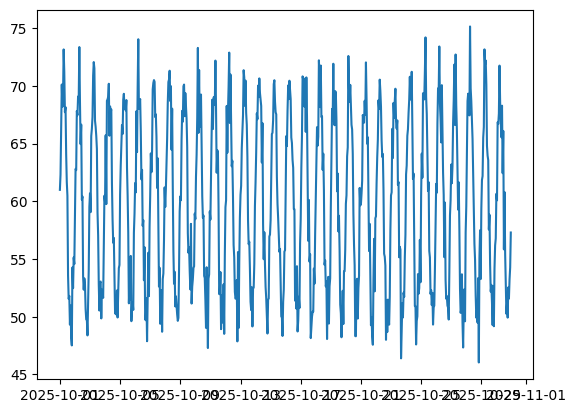

In [ ]:
# Visualize all metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('LMS Performance Metrics Over Time', fontsize=16)

# Plot first 7 days for clarity
plot_range = slice(0, 7*24)

axes[0, 0].plot(df['timestamp'][plot_range], df['server_load'][plot_range], color='blue')
axes[0, 0].set_title('Server Load (%)')
axes[0, 0].set_ylabel('CPU Usage %')
axes[0, 0].grid(True)

axes[0, 1].plot(df['timestamp'][plot_range], df['db_performance'][plot_range], color='green')
axes[0, 1].set_title('Database Performance')
axes[0, 1].set_ylabel('Query Response Time (ms)')
axes[0, 1].grid(True)

axes[1, 0].plot(df['timestamp'][plot_range], df['api_response_time'][plot_range], color='orange')
axes[1, 0].set_title('API Response Times')
axes[1, 0].set_ylabel('Response Time (ms)')
axes[1, 0].grid(True)

axes[1, 1].plot(df['timestamp'][plot_range], df['storage_capacity'][plot_range], color='red')
axes[1, 1].set_title('Storage Capacity')
axes[1, 1].set_ylabel('Storage Used (GB)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Data Preprocessing and Sequence Creation
from sklearn.preprocessing import MinMaxScaler
import os

# Metrics to predict
METRICS = ['server_load', 'db_performance', 'api_response_time', 'storage_capacity']
SEQ_LENGTH = 24  # 24 hours lookback

# Create scalers and scaled data for each metric
scalers = {}
scaled_data = {}

for metric in METRICS:
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[[metric]])
    scalers[metric] = scaler
    scaled_data[metric] = scaled

def create_sequences(data, seq_length=SEQ_LENGTH):
    """Create sequences for LSTM training"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences for each metric
sequences = {}
for metric in METRICS:
    X, y = create_sequences(scaled_data[metric], SEQ_LENGTH)
    sequences[metric] = {'X': X, 'y': y}
    print(f"{metric}: X shape = {X.shape}, y shape = {y.shape}")


In [ ]:
# Verify sequence shapes
for metric in METRICS:
    print(f"{metric}: {sequences[metric]['X'].shape}")

(696, 24, 1)

In [ ]:
# Build and Train LSTM Models for Each Metric
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Set random seed for reproducibility
tf.random.set_seed(42)

# Create models directory
os.makedirs('models', exist_ok=True)

models = {}
training_history = {}

print("Building and training models for each metric...")
print("=" * 60)

(696, 1)

In [ ]:
# Train model for Server Load
metric = 'server_load'
X = sequences[metric]['X']
y = sequences[metric]['y']

# Reshape for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split data (80% train, 20% validation)
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# Build model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dropout(0.1),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(f'models/{metric}_best.h5', monitor='val_loss', save_best_only=True)
]

# Train
print(f"\nTraining {metric} model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)

models[metric] = model
training_history[metric] = history

# Save final model
model.save(f'models/{metric}_model.h5')
print(f"✓ {metric} model saved to models/{metric}_model.h5")

In [ ]:
# Train model for Database Performance
metric = 'db_performance'
X = sequences[metric]['X']
y = sequences[metric]['y']
X = X.reshape((X.shape[0], X.shape[1], 1))

split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dropout(0.1),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(f'models/{metric}_best.h5', monitor='val_loss', save_best_only=True)
]

print(f"\nTraining {metric} model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)

models[metric] = model
training_history[metric] = history
model.save(f'models/{metric}_model.h5')
print(f"✓ {metric} model saved to models/{metric}_model.h5")


c:\Users\varshith yadav\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train model for API Response Time
metric = 'api_response_time'
X = sequences[metric]['X']
y = sequences[metric]['y']
X = X.reshape((X.shape[0], X.shape[1], 1))

split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dropout(0.1),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(f'models/{metric}_best.h5', monitor='val_loss', save_best_only=True)
]

print(f"\nTraining {metric} model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)

models[metric] = model
training_history[metric] = history
model.save(f'models/{metric}_model.h5')
print(f"✓ {metric} model saved to models/{metric}_model.h5")

In [ ]:
# Train model for Storage Capacity
metric = 'storage_capacity'
X = sequences[metric]['X']
y = sequences[metric]['y']
X = X.reshape((X.shape[0], X.shape[1], 1))

split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dropout(0.1),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(f'models/{metric}_best.h5', monitor='val_loss', save_best_only=True)
]

print(f"\nTraining {metric} model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)

models[metric] = model
training_history[metric] = history
model.save(f'models/{metric}_model.h5')
print(f"✓ {metric} model saved to models/{metric}_model.h5")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Save scalers for prediction
import joblib

os.makedirs('models/scalers', exist_ok=True)
for metric in METRICS:
    joblib.dump(scalers[metric], f'models/scalers/{metric}_scaler.pkl')
    print(f"✓ Scaler saved: models/scalers/{metric}_scaler.pkl")

print("\n" + "=" * 60)
print("All models and scalers saved successfully!")
print("=" * 60)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1389 - val_loss: 0.0748
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0728 - val_loss: 0.0634
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0590 - val_loss: 0.0528
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0462 - val_loss: 0.0324
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0192 - val_loss: 0.0086
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0105 - val_loss: 0.0062
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088 - val_loss: 0.0058
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0081 - val_loss: 0.0063
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0086 - val_loss: 0.0058
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0079 - val_loss: 0.0068
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0083 - val_loss: 0.0056
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

In [ ]:
# Make Predictions for Next 24 Hours
from tensorflow.keras.models import load_model

def predict_future(model, scaler, last_sequence, hours=24):
    """Predict next N hours"""
    predictions = []
    current_seq = last_sequence.copy()
    
    for _ in range(hours):
        # Reshape for prediction
        pred_input = current_seq.reshape((1, SEQ_LENGTH, 1))
        # Predict next value
        pred = model.predict(pred_input, verbose=0)
        predictions.append(pred[0, 0])
        # Update sequence (remove first, add prediction)
        current_seq = np.append(current_seq[1:], pred[0, 0])
    
    # Inverse transform
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    return predictions.flatten()

# Get last sequence from each metric
predictions_24h = {}
for metric in METRICS:
    last_seq = scaled_data[metric][-SEQ_LENGTH:]
    preds = predict_future(models[metric], scalers[metric], last_seq, hours=24)
    predictions_24h[metric] = preds
    print(f"\n{metric} - Next 24h predictions:")
    print(f"  Min: {preds.min():.2f}, Max: {preds.max():.2f}, Avg: {preds.mean():.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


In [ ]:
# Analyze Predictions for Scaling and Risk Assessment

def analyze_scaling_needs(predictions):
    """Determine when scaling is needed"""
    # Thresholds
    server_threshold = 80  # CPU usage %
    db_threshold = 200  # ms
    api_threshold = 150  # ms
    storage_threshold = 900  # GB
    
    scaling_alerts = []
    
    # Check server load
    if predictions['server_load'].max() > server_threshold:
        peak_hours = np.where(predictions['server_load'] > server_threshold)[0]
        scaling_alerts.append({
            'metric': 'server_load',
            'severity': 'high' if predictions['server_load'].max() > 90 else 'medium',
            'peak_hours': peak_hours.tolist(),
            'max_value': predictions['server_load'].max()
        })
    
    # Check database
    if predictions['db_performance'].max() > db_threshold:
        peak_hours = np.where(predictions['db_performance'] > db_threshold)[0]
        scaling_alerts.append({
            'metric': 'db_performance',
            'severity': 'high' if predictions['db_performance'].max() > 300 else 'medium',
            'peak_hours': peak_hours.tolist(),
            'max_value': predictions['db_performance'].max()
        })
    
    # Check API
    if predictions['api_response_time'].max() > api_threshold:
        peak_hours = np.where(predictions['api_response_time'] > api_threshold)[0]
        scaling_alerts.append({
            'metric': 'api_response_time',
            'severity': 'high' if predictions['api_response_time'].max() > 200 else 'medium',
            'peak_hours': peak_hours.tolist(),
            'max_value': predictions['api_response_time'].max()
        })
    
    # Check storage
    if predictions['storage_capacity'].max() > storage_threshold:
        scaling_alerts.append({
            'metric': 'storage_capacity',
            'severity': 'high',
            'peak_hours': [np.argmax(predictions['storage_capacity'])],
            'max_value': predictions['storage_capacity'].max()
        })
    
    return scaling_alerts

def assess_crash_risk(predictions):
    """Assess crash risk during exam periods"""
    # High risk if multiple metrics exceed thresholds simultaneously
    risk_factors = []
    
    # Server load > 90%
    if predictions['server_load'].max() > 90:
        risk_factors.append('critical_server_load')
    
    # DB > 400ms
    if predictions['db_performance'].max() > 400:
        risk_factors.append('critical_db_performance')
    
    # API > 250ms
    if predictions['api_response_time'].max() > 250:
        risk_factors.append('critical_api_latency')
    
    # Storage > 950GB
    if predictions['storage_capacity'].max() > 950:
        risk_factors.append('critical_storage')
    
    # Calculate risk score
    risk_score = len(risk_factors) / 4.0
    
    return {
        'risk_score': risk_score,
        'risk_level': 'critical' if risk_score > 0.75 else 'high' if risk_score > 0.5 else 'medium' if risk_score > 0.25 else 'low',
        'risk_factors': risk_factors,
        'recommendation': 'Immediate scaling required' if risk_score > 0.75 else 'Monitor closely' if risk_score > 0.5 else 'Normal operations'
    }

# Analyze predictions
scaling_alerts = analyze_scaling_needs(predictions_24h)
crash_risk = assess_crash_risk(predictions_24h)

print("\n" + "=" * 60)
print("SCALING ANALYSIS")
print("=" * 60)
if scaling_alerts:
    for alert in scaling_alerts:
        print(f"\n{alert['metric'].upper()}:")
        print(f"  Severity: {alert['severity']}")
        print(f"  Max Value: {alert['max_value']:.2f}")
        print(f"  Peak Hours: {alert['peak_hours']}")
else:
    print("No immediate scaling needs detected.")

print("\n" + "=" * 60)
print("CRASH RISK ASSESSMENT")
print("=" * 60)
print(f"Risk Score: {crash_risk['risk_score']:.2%}")
print(f"Risk Level: {crash_risk['risk_level'].upper()}")
print(f"Risk Factors: {', '.join(crash_risk['risk_factors']) if crash_risk['risk_factors'] else 'None'}")
print(f"Recommendation: {crash_risk['recommendation']}")
print("=" * 60)

np.float32(59.524433)

In [ ]:
# Visualize Predictions
future_timestamps = pd.date_range(
    start=df['timestamp'].iloc[-1] + timedelta(hours=1),
    periods=24,
    freq='h'
)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('24-Hour Predictions for LMS Performance Metrics', fontsize=16)

# Historical data (last 7 days)
hist_range = slice(-7*24, None)

axes[0, 0].plot(df['timestamp'][hist_range], df['server_load'][hist_range], label='Historical', alpha=0.7)
axes[0, 0].plot(future_timestamps, predictions_24h['server_load'], label='Predicted', color='red', linewidth=2)
axes[0, 0].axhline(y=80, color='orange', linestyle='--', label='Scaling Threshold')
axes[0, 0].set_title('Server Load Prediction')
axes[0, 0].set_ylabel('CPU Usage %')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(df['timestamp'][hist_range], df['db_performance'][hist_range], label='Historical', alpha=0.7)
axes[0, 1].plot(future_timestamps, predictions_24h['db_performance'], label='Predicted', color='red', linewidth=2)
axes[0, 1].axhline(y=200, color='orange', linestyle='--', label='Scaling Threshold')
axes[0, 1].set_title('Database Performance Prediction')
axes[0, 1].set_ylabel('Response Time (ms)')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(df['timestamp'][hist_range], df['api_response_time'][hist_range], label='Historical', alpha=0.7)
axes[1, 0].plot(future_timestamps, predictions_24h['api_response_time'], label='Predicted', color='red', linewidth=2)
axes[1, 0].axhline(y=150, color='orange', linestyle='--', label='Scaling Threshold')
axes[1, 0].set_title('API Response Time Prediction')
axes[1, 0].set_ylabel('Response Time (ms)')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(df['timestamp'][hist_range], df['storage_capacity'][hist_range], label='Historical', alpha=0.7)
axes[1, 1].plot(future_timestamps, predictions_24h['storage_capacity'], label='Predicted', color='red', linewidth=2)
axes[1, 1].axhline(y=900, color='orange', linestyle='--', label='Scaling Threshold')
axes[1, 1].set_title('Storage Capacity Prediction')
axes[1, 1].set_ylabel('Storage Used (GB)')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print("\n✓ Model training and prediction complete!")
print("✓ All models saved in 'models/' directory")
print("✓ Ready for FastAPI deployment")
